In [1]:
import numpy as np
import pandas as pd
import json
import os
import torch
import torch.nn.functional as F
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
from transformers import BartForConditionalGeneration, BartTokenizer, AdamW
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score

nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/tobysavage/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/tobysavage/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:

directory = '../../data/LARGE'

for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        print(filename)


test_final_csv
train.json
ambignq.zip
dev_final_csv
dev.json
LICENSE
train_final_csv


In [21]:
df_train = pd.read_csv('../../data/LARGE/train_final_csv')
df_train = df_train.drop(columns='viewed_doc_titles')
df_train = df_train.drop(columns='question_type')
print("Train Length: ", len(df_train))
df_train.head()

Train Length:  9216


,ambiguous_question,disambiguated_question
0,Who sang island in the sun in aquamarine?,"Who from the cast sings ""Island in the Sun"" i..."
1,Who sang island in the sun in aquamarine?,"Who sings ""Island in the Sun"" that is featured..."
2,What was the first sign that mt. pinatubo had ...,What was the first sign that mt. pinatubo had ...
3,What was the first sign that mt. pinatubo had ...,What was the first sign that mt. pinatubo had ...
4,What was the first sign that mt. pinatubo had ...,What was the first sign that mt. pinatubo had ...


In [22]:
df_test = pd.read_csv('../../data/LARGE/test_final_csv')
df_test = df_test.drop(columns='viewed_doc_titles')
df_test = df_test.drop(columns='question_type')
print("Test Length: ", len(df_test))
df_test.head()

Test Length:  4866


,ambiguous_question,disambiguated_question
0,Who plays the queen in chronicles of narnia?,Who plays Queen Jadis in Chronicles of Narnia?
1,Who plays the queen in chronicles of narnia?,Who plays Queen Lilliandil in Chronicles of Na...
2,How many championships do new york knicks have?,How many NBA championships do new york knicks ...
3,How many championships do new york knicks have?,How many Eastern Conference/Division champions...
4,How far is vidor tx from beaumont tx?,How far is Vidor TX from Beaumont TX by car?


In [23]:
assert len(df_train)+len(df_test)==14082

In [24]:
df_dev = pd.read_csv('../../data/LARGE/dev_final_csv')
print("Dev Length: ", len(df_dev))
df_dev.head()

Dev Length:  4856


,ambiguous_question,disambiguated_question
0,Why did the st louis cardinals move to arizona?,What ability caused the st louis cardinals mov...
1,Why did the st louis cardinals move to arizona?,What physical issue caused the st louis cardin...
2,Why did the st louis cardinals move to arizona?,What fan issue caused the st louis cardinals m...
3,Who is the current chairman of african union c...,Who is the 4th chairman of african union commi...
4,Who is the current chairman of african union c...,Who is the 3rd chairman of african union commi...


In [25]:
# CITATION: HuggingFace on how to fine-tune a model (https://huggingface.co/docs/transformers/training)
# Also used help from previous homework assignments from NNDL and ADL of this semester.
# Help from ChatGPT on data type/syntax on specific data values
# This goes for the initialization of the tokenizer, model, and training loop.

# tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')
# Load pre-trained model
# model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')
model.config.dropout = 0.1

# move the model to the GPU
model.to('cuda')

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_norm): LayerN

In [26]:
inputs_train = list(df_train['ambiguous_question'])
targets_train = list(df_train['disambiguated_question'])

# Tokenize inputs and targets
inputs_train = tokenizer(inputs_train, padding=True, truncation=True, return_tensors='pt')
targets_train = tokenizer(targets_train, padding=True, truncation=True, return_tensors='pt')

In [27]:
# CITATION: Class produced by ChatGPT to process specific data into dataloader.
class AmbigNQDataset(Dataset):
    def __init__(self, encodings, resultings):
        self.encodings = encodings
        self.resultings = resultings
        
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.resultings['input_ids'][idx]
        return item
    
    def __len__(self):
        return len(self.resultings['input_ids'])
    
dataset_train = AmbigNQDataset(inputs_train, targets_train)
loader_train = DataLoader(dataset_train, batch_size = 10, shuffle=True)

In [28]:
# CITATION: Inspiration from  NNDL and ADL coursework on formatting

inputs_dev = list(df_dev['ambiguous_question'])
targets_dev = list(df_dev['disambiguated_question'])

inputs_dev = tokenizer(inputs_dev, padding=True, truncation=True, return_tensors='pt')
targets_dev = tokenizer(targets_dev, padding=True, truncation=True, return_tensors='pt')
dataset_dev = AmbigNQDataset(inputs_dev, targets_dev)
loader_dev = DataLoader(dataset_dev, batch_size = 10, shuffle = True)

In [29]:
# CITATION: Inspiration from  NNDL and ADL coursework on formatting

inputs_test = list(df_test['ambiguous_question'])
targets_test = list(df_test['disambiguated_question'])

inputs_test = tokenizer(inputs_test, padding=True, truncation=True, return_tensors='pt')
targets_test = tokenizer(targets_test, padding=True, truncation=True, return_tensors='pt')
dataset_test = AmbigNQDataset(inputs_test, targets_test)
loader_test = DataLoader(dataset_test, batch_size = 10, shuffle = False)

# Fine-tuning BART-Large

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [32]:
# CITATION: HuggingFace on how to fine-tune a model (https://huggingface.co/docs/transformers/training)
# Also used help from previous homework assignments from NNDL and ADL of this semester.
# Help from ChatGPT on data type/syntax on specific data values
# This goes for the initialization of the tokenizer, model, and training loop.

# load pre-trained BART-Large model for fine-tuning
epochs = 5
# model = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

# Early Stopping Parameters
patience = 2
min_delta = 0.001
best_val_loss = np.inf
patience_counter = 0

training_losses = []
validation_losses = []

# training loop
model.train() # put model in train mode
for epoch in range(epochs):
    total_train_loss = 0
    for batch in loader_train:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        resultings = batch['labels'].to('cuda')
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=resultings)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_train_loss +=loss.item()
        
    avg_train_loss = total_train_loss / len(loader_train)
    training_losses.append(avg_train_loss)
    print(f"Epoch: {epoch}, Training Loss: {avg_train_loss}")
    
    
    # Validation Step
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in loader_dev:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss/len(loader_dev)
    validation_losses.append(avg_val_loss)
    print(f"Epoch: {epoch}, Validation Loss: {avg_val_loss}")
    
    if avg_val_loss + min_delta < best_val_loss:
        best_val_loss = avg_val_loss
        # CITATION: Early Stopping with a patients counter implemented suggested from ChatGPT
        patience_counter = 0  # reset counter if improvement is found
    else:
        patience_counter += 1  # increment counter if no improvement

    if patience_counter >= patience:
        print("Stopping early due to no improvement in validation loss.")
        break
    
    model.train()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0, Training Loss: 1.8261441015789928
Epoch: 0, Validation Loss: 0.2675297122923926
Epoch: 1, Training Loss: 0.266465969060481
Epoch: 1, Validation Loss: 0.2516861463525168
Epoch: 2, Training Loss: 0.22710071321487943
Epoch: 2, Validation Loss: 0.24580122366424942
Epoch: 3, Training Loss: 0.20067720467511588
Epoch: 3, Validation Loss: 0.24744277234369344
Epoch: 4, Training Loss: 0.17876775348619628
Epoch: 4, Validation Loss: 0.2564451183679173
Stopping early due to no improvement in validation loss.


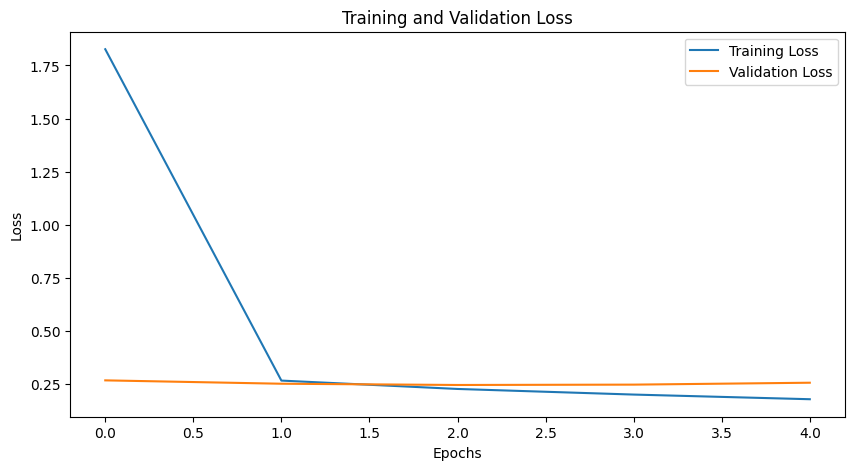

In [33]:
# cpu_training_loss = [loss_item.item() for loss_item in training_losses]

plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
# CITATION: HuggingFace on how to fine-tune a model (https://huggingface.co/docs/transformers/training)
# Also used help from previous homework assignments from NNDL and ADL of this semester.
# Help from ChatGPT on data type/syntax on specific data values
# This goes for the initialization of the tokenizer, model, and training loop.

model.eval()  # make sure the model is in evaluation mode
predictions = []
references = []

with torch.no_grad():
    for batch in loader_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        
        # Decode predictions
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        # print("BATCH: ", batch)
        # print("PREDS: ", pred_texts)
        predictions.extend(pred_texts)
        
        ref_texts = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        
        input_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        
        # for i in range(len(pred_texts)):
        #     print(f"INPUT: {input_texts[i]}")
        #     print(f"ACTUAL: {ref_texts[i]}")
        #     print(f"PREDICTION: {pred_texts[i]}")
        #     print("\n")
        
        references.extend([[ref] for ref in ref_texts])
        # break

In [54]:
# CITATION: Inspiration from NLTK (https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
tokenized_predictions = [pred.split() for pred in predictions]
tokenized_references = [[ref[0].split()] for ref in references]

# Calculate BLEU score
bleu_score = corpus_bleu(tokenized_references, tokenized_predictions)

# Calculate METEOR score
# meteor_scores = [meteor_score([ref[0]], pred) for ref, pred in zip(references, predictions)]
# average_meteor_score = sum(meteor_scores) / len(meteor_scores)

print(f"Corpus BLEU Score on Test Set: {bleu_score}")
# print(f"Average METEOR Score on Test Set: {average_meteor_score}")

Corpus BLEU Score on Test Set: 0.38033264463139393


In [56]:
# CITATION: Inspiration from NLTK (https://www.nltk.org/api/nltk.translate.meteor_score.html)

# Tokenize the predictions for METEOR score calculation
tokenized_predictions_meteor = [pred.split() for pred in predictions]

# Check the structure of your references
# If each item in references is a list with a single string
tokenized_references_meteor = [[ref[0].split()] if len(ref) > 0 else [[]] for ref in references]

# Calculate METEOR score
meteor_scores = [meteor_score(refs, pred) for refs, pred in zip(tokenized_references_meteor, tokenized_predictions_meteor)]
average_meteor_score = sum(meteor_scores) / len(meteor_scores)

print(f"Average METEOR Score on Test Set: {average_meteor_score}")


Average METEOR Score on Test Set: 0.6238789965717016


In [57]:
model.save_pretrained('final_pretrained_saves')
tokenizer.save_pretrained('final_pretrained_saves')

('final_pretrained_saves/tokenizer_config.json',
 'final_pretrained_saves/special_tokens_map.json',
 'final_pretrained_saves/vocab.json',
 'final_pretrained_saves/merges.txt',
 'final_pretrained_saves/added_tokens.json')

# Load the Model

In [59]:
model = BartForConditionalGeneration.from_pretrained('final_pretrained_saves').to(device)

In [60]:
model.eval()  # make sure the model is in evaluation mode
predictions = []
references = []

with torch.no_grad():
    for batch in loader_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # Generate the outputs using the model
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask)
        
        # Decode predictions
        pred_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        # print(pred_texts)
        predictions.extend(pred_texts)
        
        # Decode the reference labels
        ref_texts = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        input_texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        
        for i in range(len(pred_texts)):
            print(f"INPUT: {input_texts[i]}")
            print(f"ACTUAL: {ref_texts[i]}")
            print(f"PREDICTION: {pred_texts[i]}")
            print("\n")
        
        references.extend([[ref] for ref in ref_texts])
        # break


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


INPUT: Who plays the queen in chronicles of narnia?
ACTUAL: Who plays Queen Jadis in Chronicles of Narnia?
PREDICTION: Who plays the queen in chronicles of narnia as adult?


INPUT: Who plays the queen in chronicles of narnia?
ACTUAL: Who plays Queen Lilliandil in Chronicles of Narnia?
PREDICTION: Who plays the queen in chronicles of narnia as adult?


INPUT: How many championships do new york knicks have?
ACTUAL: How many NBA championships do new york knicks have?
PREDICTION: How many NBA championships do new york knicks have?


INPUT: How many championships do new york knicks have?
ACTUAL: How many Eastern Conference/Division championships do new york knicks have?
PREDICTION: How many NBA championships do new york knicks have?


INPUT: How far is vidor tx from beaumont tx?
ACTUAL: How far is Vidor TX from Beaumont TX by car?
PREDICTION: How far is vidor tx from beaumont tx in miles?


INPUT: How far is vidor tx from beaumont tx?
ACTUAL: How far is Vidor TX from Beaumont TX in a south

KeyboardInterrupt: 